In [36]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter, FormatStrFormatter
import math
import numpy as np

In [188]:
n_measurements = 20 #no. of different values used
max_gRate = 0.083
immigration_rate = 0.8
K = 10000
#when deterioration greater than this value we change from immigration dominated to deterioration dominated
phase2_lim = immigration_rate/K 
phase2_lim_scaled = phase2_lim/max_gRate

N_thresh_min = 0. #range of values for N*
N_thresh_max = 1.5
delta_N_thresh = (N_thresh_max - N_thresh_min)/n_measurements

det_ratio_min = 0. #range of values for deterioration ratio
det_ratio_max = 1.5
delta_det_ratio = (det_ratio_max - det_ratio_min)/n_measurements

det_ratio_vals = np.linspace(det_ratio_min, det_ratio_max, 101)

In [215]:
dashed_line_vals = pd.read_csv("chris_deterministic_data/dashed_im0.8_mig0.8.dat", delimiter=" ", header=None, skiprows=1, names=["r_det_ratio", "N_theory"])
dashed_line_vals

,r_det_ratio,N_theory
0,0.001,1.456083
1,0.006,1.452800
2,0.011,1.449528
3,0.016,1.446246
4,0.021,1.442978
...,...,...
155,0.776,1.011565
156,0.781,1.009146
157,0.786,1.006723
158,0.791,1.004311


In [137]:
def phase_diag_line(r_det_g):
    '''
    This method calculates the theoretical blue line used for the time to first microhabitat phase diagram.
    
    Given by eqn 3 (subject to change) in the biofilm threshold theory paper
    
    r_det_g is a value of r_det/g_max
    '''
    
#     N_plus = K*(1 - r_det_g)*(0.5 + 0.5*(1. + (4.*immigration_rate)/(max_gRate*K*(1 - r_det_g)**0.5) ))
#     N_minus = K*(1 - r_det_g)*(0.5 - 0.5*(1. + (4.*immigration_rate)/(max_gRate*K*(1 - r_det_g)**0.5) ))
    
#     N_plus  = (1. - r_det_g)*(0.5+0.5*(1+(4.*immigration_rate/(max_gRate*K*(1 - r_det_g)**2)))**0.5)
#     N_minus = (1. - r_det_g)*(0.5-0.5*(1+(4.*immigration_rate/(max_gRate*K*(1 - r_det_g)**2)))**0.5)
    N_plus  = (1. - r_det_g)*(0.5 + 0.5*(1 + (4.*immigration_rate/((1 - r_det_g)**2)))**0.5)
    N_minus = (1. - r_det_g)*(0.5 - 0.5*(1 + (4.*immigration_rate/((1 - r_det_g)**2)))**0.5)
    
    return np.max([N_plus, N_minus])
    
    

In [126]:
df2 = pd.read_csv("timeTo1Microhab_phaseDiagram_bigK/mhLim-1_N^-1.500_rDet-0.225.csv")
new_df = pd.DataFrame(df2.mean().to_dict(),index=[df2.index.values[-1]])
new_df["time_to_n_stDev"] = df2["time_to_n"].std()
new_df["coeff_variation"] = df2["time_to_n"].std()/df2["time_to_n"].mean()
new_df
#df2

,n_thresh,det_ratio,time_to_n,time_elapsed,time_to_n_stDev,coeff_variation
23,1.5,0.225,25.85,9.000000e+09,0.381644,0.014764


In [127]:
df_list = [] #empty list to hold all the dataframes
#iterate through all the seperate csv files and append them to the list
for n in range(n_measurements+1):
    for d in range(n_measurements+1):
        n_thresh = N_thresh_min + n*(delta_N_thresh)
        det_ratio = det_ratio_min + d*(delta_det_ratio)
        
        n_thresh_str = "{:.3f}".format(n_thresh)
        det_ratio_str = "{:.3f}".format(det_ratio)
        
        df = pd.read_csv("timeTo1Microhab_phaseDiagram_bigK/mhLim-1_N^-"+n_thresh_str+"_rDet-"+det_ratio_str+".csv")
        df['time_to_n_raw'] = df['time_to_n']
        df['time_to_n'] = df['time_to_n']*max_gRate
        
        averaged_df = pd.DataFrame(df.mean().to_dict(),index=[df.index.values[-1]])
        averaged_df["time_to_n_stDev"] = df["time_to_n"].std()
        averaged_df["coeff_variation"] = df["time_to_n"].std()/df["time_to_n"].mean() if df["time_to_n"].mean() > 0 else None

        df_list.append(averaged_df)
        

In [307]:
#add all the dataframes together
param_data = pd.concat(df_list ,ignore_index=True)
#param_data = param_data.rename({'det_rate_ratio': 'det_rate'}, axis='columns')
#param_data['det_ratio'] = param_data['det_rate']/max_gRate
#param_data['time_adjusted'] = 0 if math.isclose(param_data['time_to_n'], 0) and param_data["time_elapsed"] > 5e5

# if param_data['time_to_n'] == 0 and param_data["time_elapsed"] > 5e5:
#     param_data['time_adjusted'] = 0.
    
# elif param_data['time_to_n'] == 0  and param_data["time_elapsed"] < 5e5:
#     param_data['time_adjusted'] = None
    
# else: param_data['time_adjusted'] = param_data['time_to_n']
#filterinfDataframe = dfObj[(dfObj['Sale'] > 30) & (dfObj['Sale'] < 33) ]
#
param_data['tN_adjusted'] = param_data["time_to_n"]
param_data['tN_adjusted'][(param_data['time_to_n'] == 0.) & (param_data['time_elapsed'] > 5e5)] = 0.
param_data['tN_adjusted'][(param_data['time_to_n'] == 0.) & (param_data['time_elapsed'] < 5e5)] = None

param_data['tN_stDev_adjusted'] = param_data["time_to_n_stDev"]
param_data['tN_stDev_adjusted'][(param_data['time_to_n'] == 0.) & (param_data['time_elapsed'] > 5e5)] = 0.
param_data['tN_stDev_adjusted'][(param_data['time_to_n'] == 0.) & (param_data['time_elapsed'] < 5e5)] = None

param_data['stochasticity'] = param_data['tN_stDev_adjusted']
param_data['stochasticity'][(param_data['stochasticity'] > 0.) & param_data['stochasticity']] = param_data['tN_stDev_adjusted']/param_data['tN_adjusted']

#this line below is essential for some reason to avoid duplicate entries
param_data[param_data['time_to_n'] > 0]

print(len(param_data.index))
print(np.nanmean(param_data["tN_adjusted"]))
print(np.nanmedian(param_data["tN_adjusted"]))
#just fiddling around here to limit the range of values in the colour bar
param_data["tN_adjusted"][param_data["tN_adjusted"] > 3] = 3
param_data["coeff_variation"][(param_data["coeff_variation"] > 0.22) | (param_data["tN_adjusted"] > 3)] = None
#param_data["coeff_variation"][param_data["tN_adjusted"] > 3] = None



441
0.9974744917161228
0.7222729166666667


In [287]:
pivot = param_data.pivot(index='n_thresh', columns='det_ratio', values='tN_adjusted')

In [288]:
theoryvals = np.vectorize(phase_diag_line)(det_ratio_vals)

1.52469507659596
0.6787087810503355
1.45608311
1.00191157


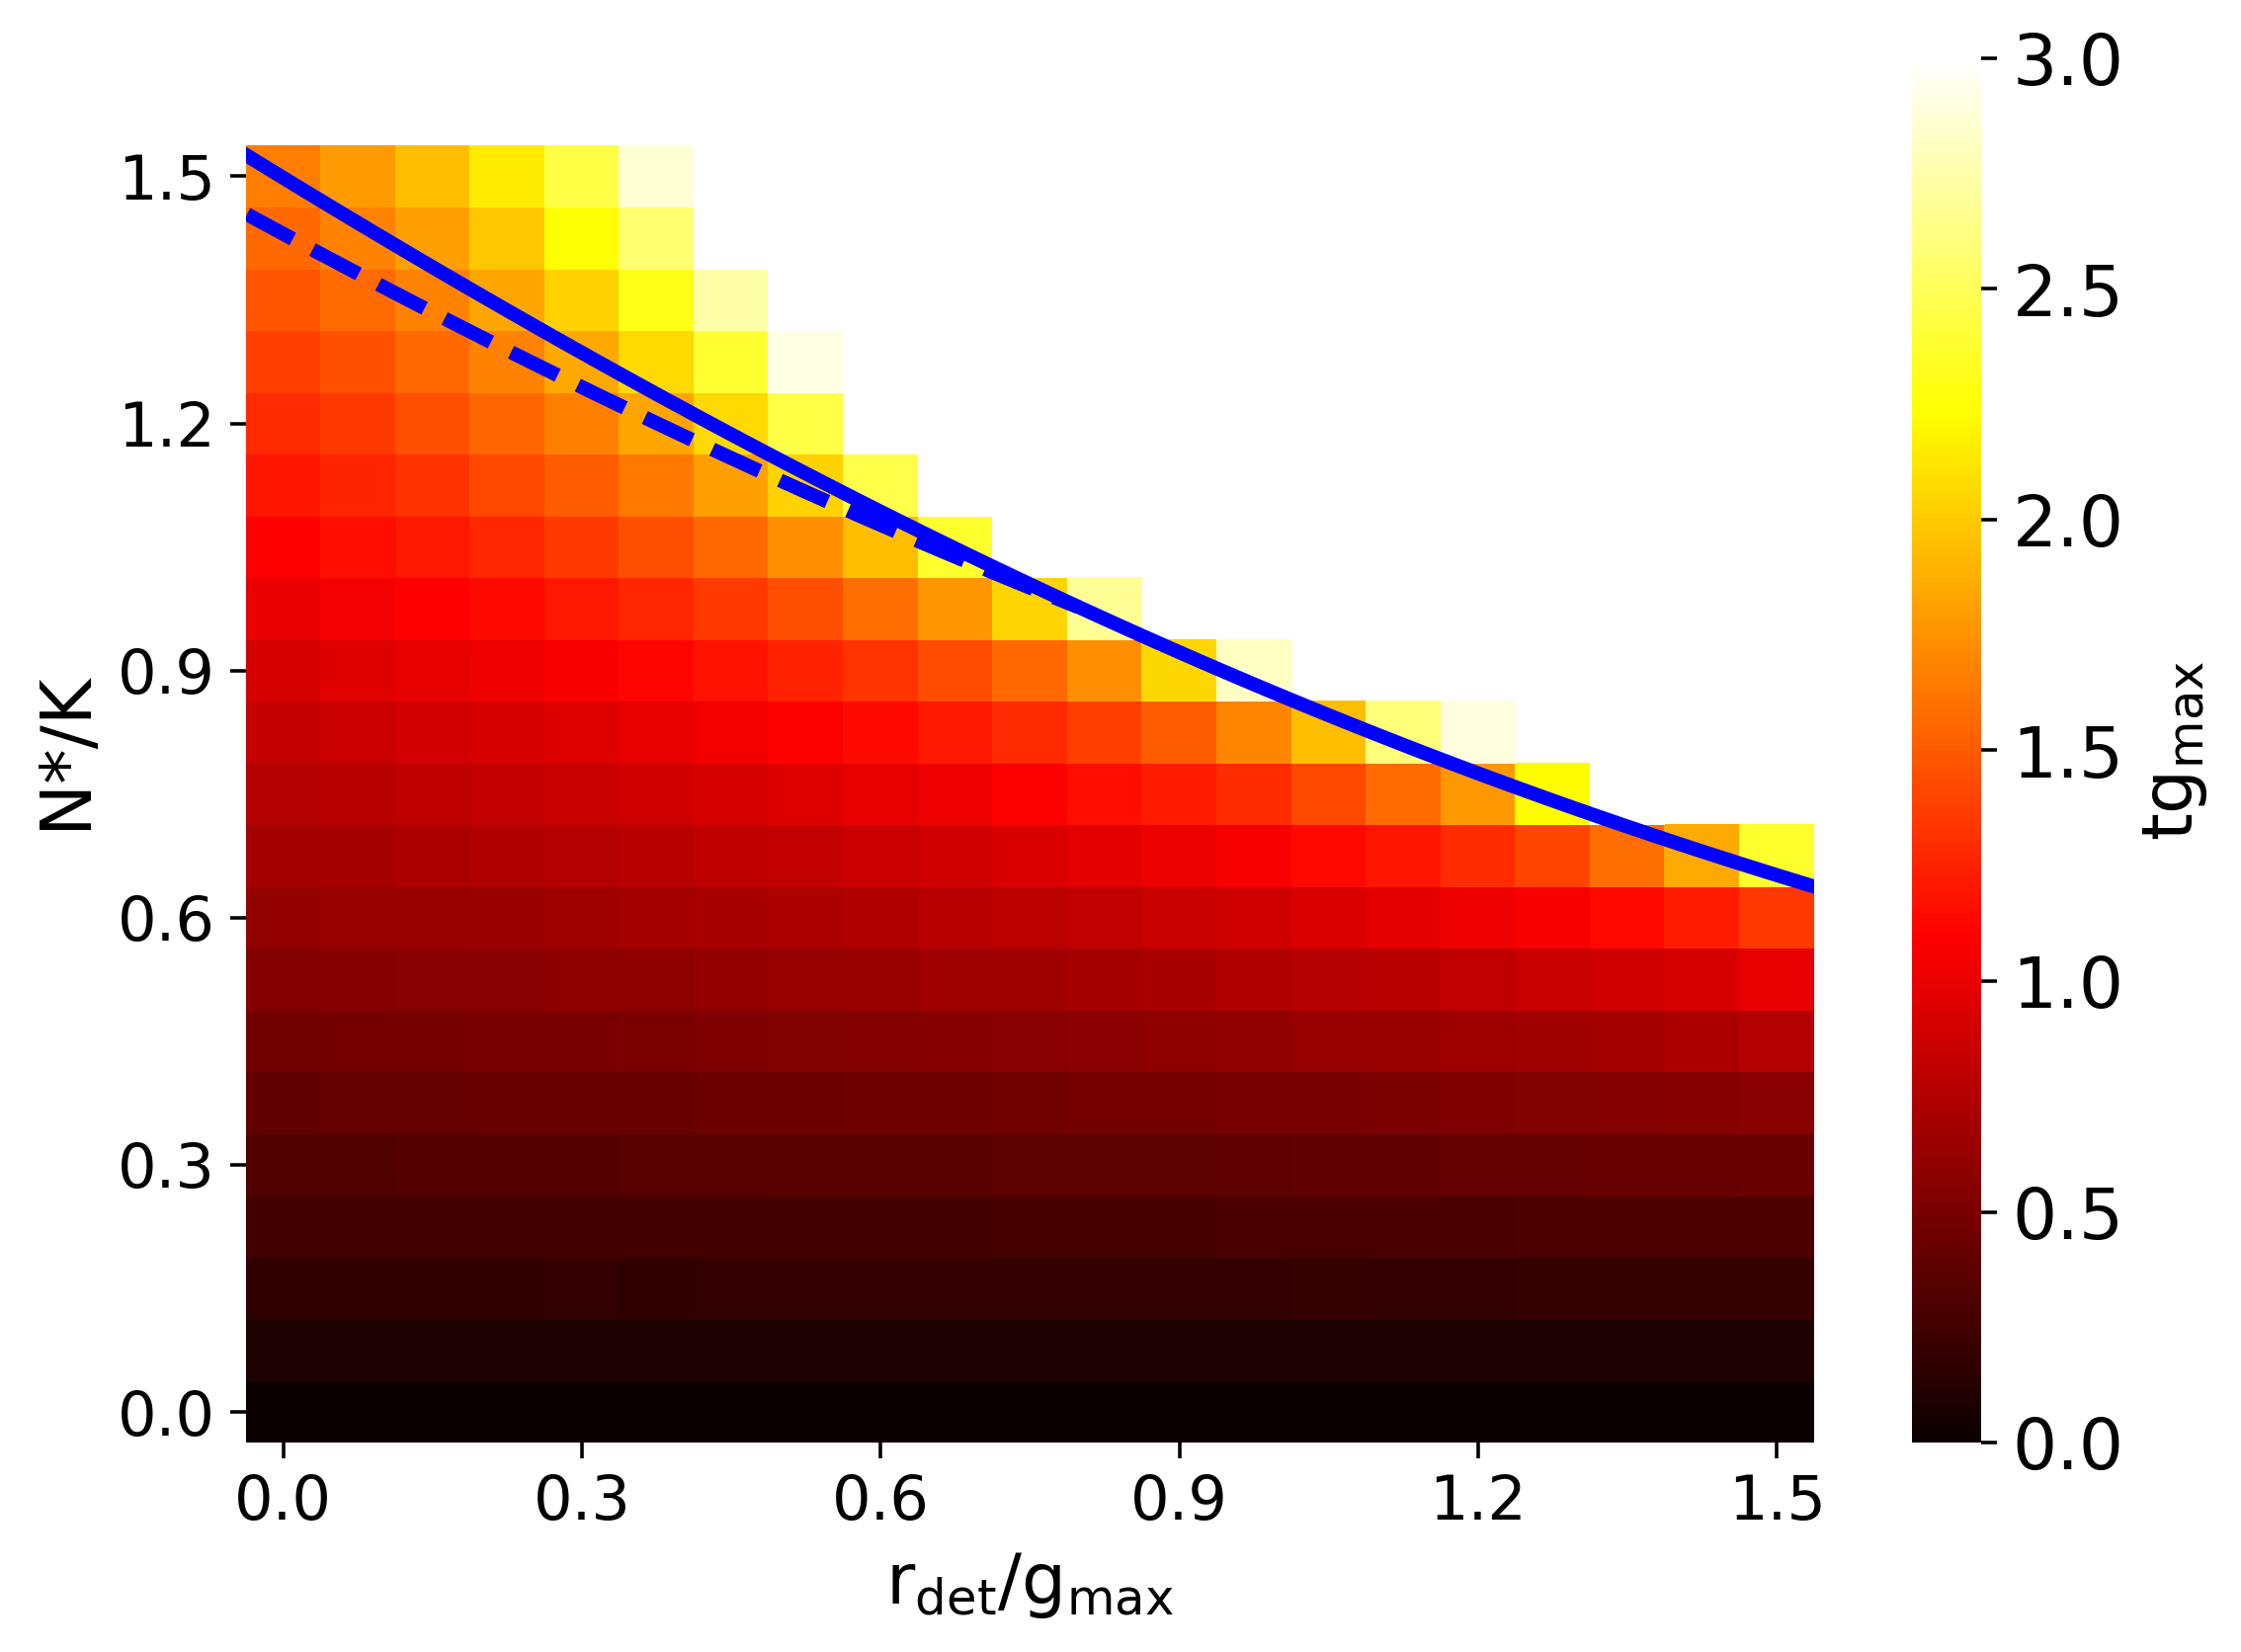

In [316]:
fig, ax = plt.subplots(dpi=320)
fig.set_size_inches(8, 5.8)
titleSize = 16
labelSize = 16
numbersize = 14
legendsize = 10
IDsize=12


# #this mask will only plot values between 15 and 20
# masko = (pivot < 15) | (pivot >= 20)

# #phase_mask = (pivot['det_ratio']) > 0.5

ax = sns.heatmap(pivot, annot=False, cmap='hot', xticklabels = 4, yticklabels=4, rasterized=True)
# ax_masked = sns.heatmap(pivot, mask=masko, cmap='Greens', cbar=False, annot=True)
# #ax_masked2 = sns.heatmap(pivot, mask=phase_mask, cmap='Blues', cbar=False, annot=True)

ax.invert_yaxis()
labels_x = [label.get_text() for label in ax.get_xticklabels()]
ax.set_xticklabels(map(lambda x: "{:.1f}".format(float(x)), labels_x))
labels_y = [label.get_text() for label in ax.get_yticklabels()]
ax.set_yticklabels(map(lambda y: "{:.1f}".format(float(y)), labels_y))


#plot the theoretical blue line
theoryN_vals = np.vectorize(phase_diag_line)(det_ratio_vals)
# theoryN_vals[0] = 1.5
# theoryN_vals[-1] = 0.6
print(theoryN_vals[0])
print(theoryN_vals[-1])

#in order to get the line to be positioned correctly, need to multiply it by this scale factor.
#equal to the max value of the line divided by no. of squares in each axis
nsquares = len(param_data.index)**0.5 #no. of squares in each axis
scale_factor_x = nsquares/1.5
scale_factor_y = nsquares/1.5
sns.lineplot(x=det_ratio_vals*scale_factor_x, y=theoryN_vals*scale_factor_y, linewidth = 3.2, color="blue")
line = ax.lines[0] # get the line
line.set_ydata(line.get_ydata() - 0.5)

#line.set_xdata(line.get_xdata() - 0.5)


#plot the dashed line
det_ratio_vals_dashed = dashed_line_vals["r_det_ratio"]
theoryN_vals_dashed = dashed_line_vals["N_theory"]
print(theoryN_vals_dashed[0])
print(np.min(theoryN_vals_dashed))

scale_factor_x_dashed = nsquares/1.5
scale_factor_y_dashed = nsquares/1.5

sns.lineplot(x=det_ratio_vals_dashed*scale_factor_x_dashed, y=theoryN_vals_dashed*scale_factor_y_dashed, linewidth = 3.2, color="blue")
line = ax.lines[1] # get the line
line.set_ydata(line.get_ydata() - 0.5)
line.set_linestyle("--")
# line.set_xdata(line.get_xdata() + 0.5)
#ax.plot(det_ratio_vals_dashed, theoryN_vals_dashed)

ax.axis('tight')

ax.set_xlabel('r$_{\\rm det}/\\rm{g}_{\max}$', fontsize=labelSize)
ax.set_ylabel('N*/K', fontsize=labelSize)
ax.xaxis.set_tick_params(labelsize=numbersize)
# ax2.xaxis.set_tick_params(labelsize=numbersize+5)
ax.yaxis.set_tick_params(labelsize=numbersize)

# ax2.set_xticks([phase2_lim_scaled])
# ax2.set_xticklabels(["$\\frac{r_{imm}}{g_{\max}K}$"])

#ax.axvline((immigration_rate-0.008)*scale_factor_x, color="black")

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=labelSize)
cbar.set_label("tg$_{\max}$", fontsize=labelSize)

plt.xticks(rotation=0)
plt.savefig('paper_plots/timeTo1Mh_heatmap.pdf', bbox_inches='tight')
plt.show()

In [308]:
pivot_stDev = param_data.pivot(index='n_thresh', columns='det_ratio', values='coeff_variation')

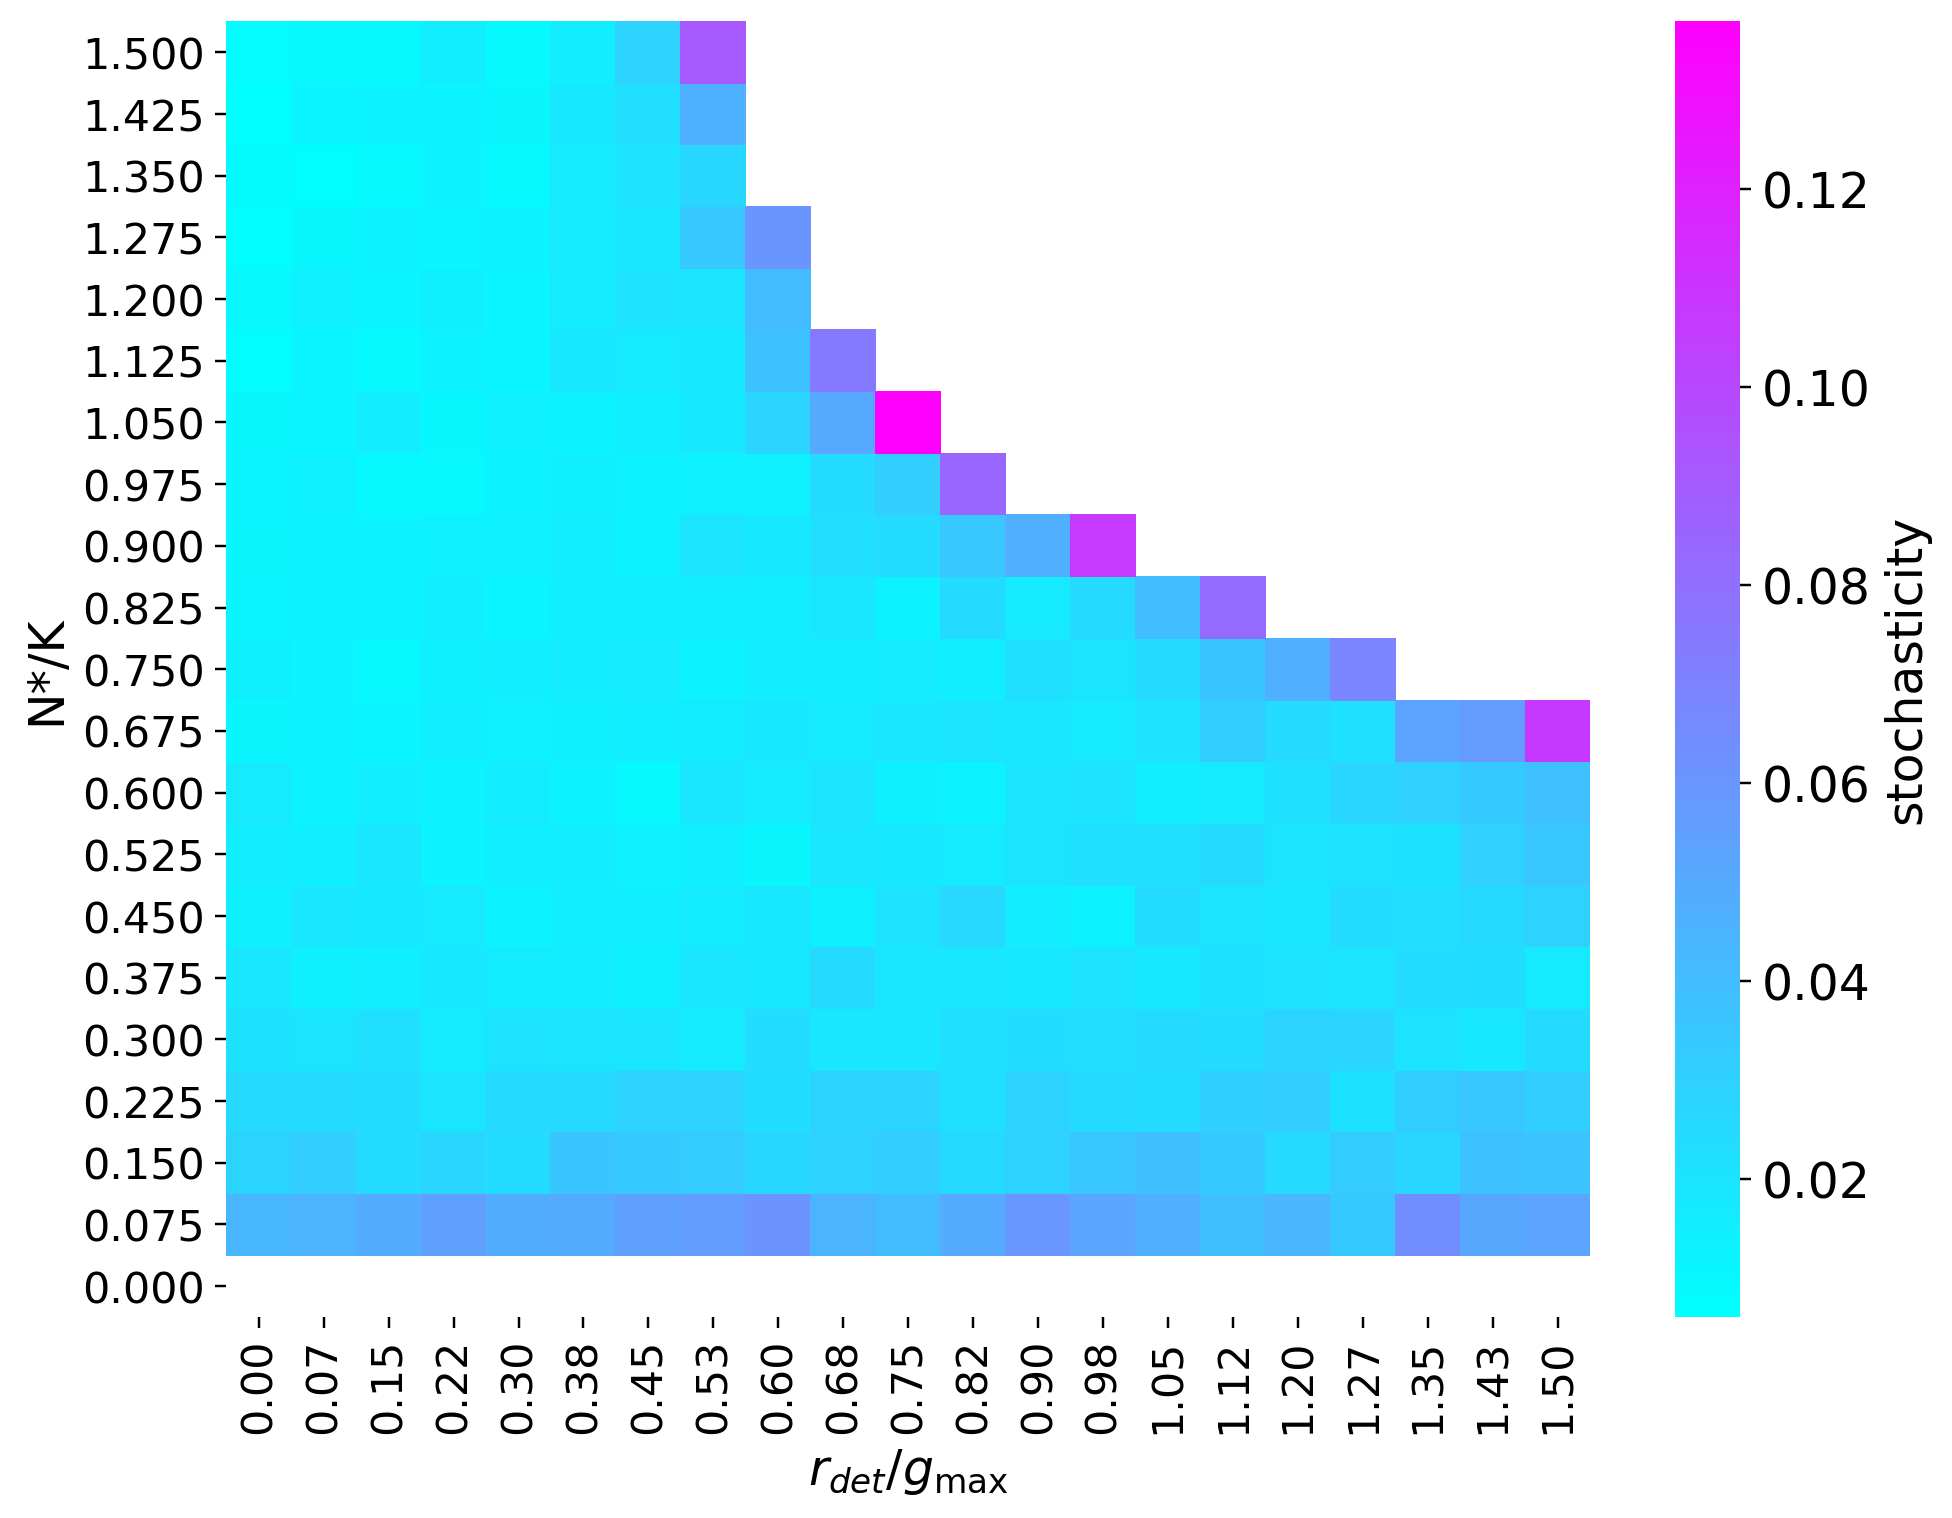

In [309]:
fig, ax = plt.subplots(dpi=220)
fig.set_size_inches(10, 7.8)
titleSize = 16
labelSize = 16
numbersize = 14
legendsize = 10
IDsize=12


# #this mask will only plot values between 15 and 20
# masko = (pivot < 15) | (pivot >= 20)

# #phase_mask = (pivot['det_ratio']) > 0.5

ax = sns.heatmap(pivot_stDev, annot=False, cmap='cool')
# ax_masked = sns.heatmap(pivot, mask=masko, cmap='Greens', cbar=False, annot=True)
# #ax_masked2 = sns.heatmap(pivot, mask=phase_mask, cmap='Blues', cbar=False, annot=True)
#ax.collections[0].colorbar.ax.set_ylim(0,1.2)

ax.invert_yaxis()
labels_x = [label.get_text() for label in ax.get_xticklabels()]
ax.set_xticklabels(map(lambda x: "{:.2f}".format(float(x)), labels_x))
labels_y = [label.get_text() for label in ax.get_yticklabels()]
ax.set_yticklabels(map(lambda y: "{:.3f}".format(float(y)), labels_y))

# ax2 = ax.twiny()
# ax2.set_xlim(0.078, 0.92)
# ax2.axvline(x=phase2_lim/max_gRate, linewidth=4, color='r')
# print(phase2_lim/max_gRate)

ax.set_xlabel('$r_{det}/g_{\max}$', fontsize=labelSize)
ax.set_ylabel('N*/K', fontsize=labelSize)
ax.xaxis.set_tick_params(labelsize=numbersize)
# ax2.xaxis.set_tick_params(labelsize=numbersize+5)
ax.yaxis.set_tick_params(labelsize=numbersize)

# ax2.set_xticks([phase2_lim_scaled])
# ax2.set_xticklabels(["$\\frac{r_{imm}}{g_{\max}K}$"])

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=labelSize)
cbar.set_label("stochasticity", fontsize=labelSize)

#plt.savefig('plots/optimalNThreshAndRDet.pdf')
plt.show()

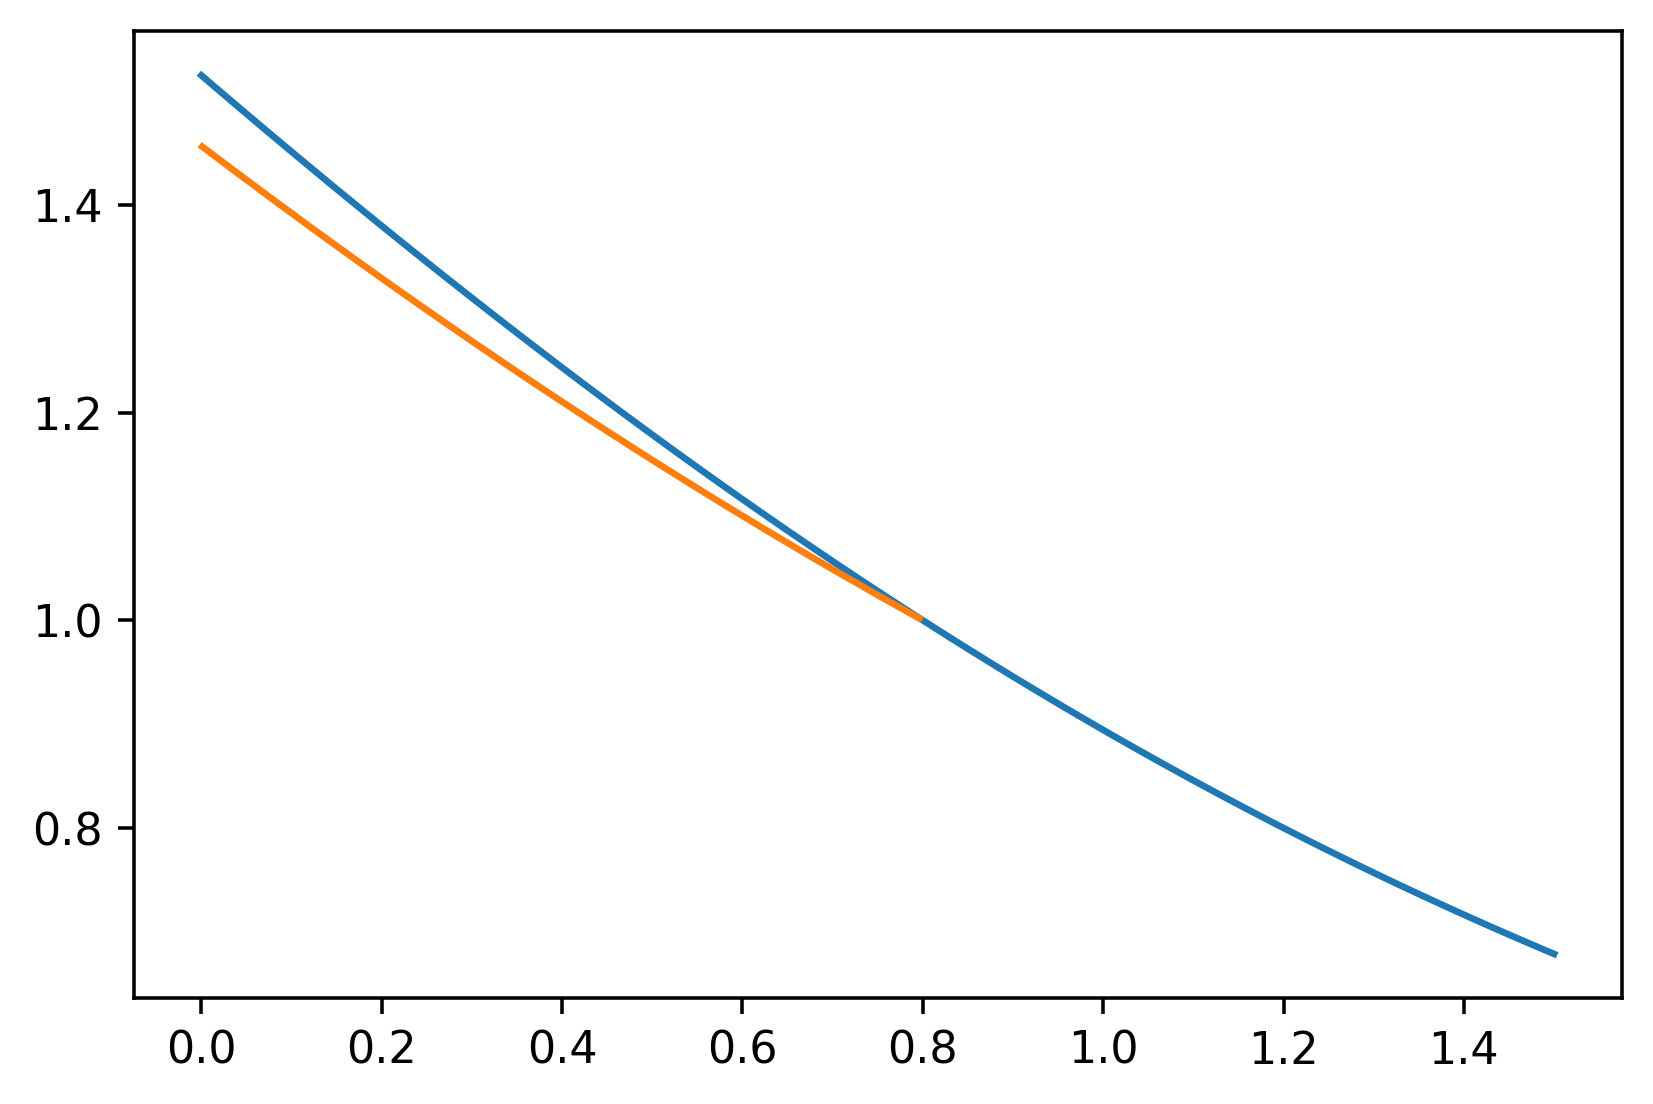

In [218]:
fig, ax = plt.subplots(dpi=320)
ax.plot(det_ratio_vals, np.vectorize(phase_diag_line)(det_ratio_vals))

det_ratio_vals_dashed = dashed_line_vals["r_det_ratio"]
theoryN_vals_dashed = dashed_line_vals["N_theory"]

ax.plot(det_ratio_vals_dashed, theoryN_vals_dashed)